In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Lorenz(object):
    def __init__(self, sigma=10., beta=8./3, rho=28.):
        self.sigma = sigma
        self.beta = beta
        self.rho = rho
        self.x = np.array([10.0, 10.0, 10.0])*np.random.randn(3); print(self.x)
        self.scale = 35
        self.Z = self.x/self.scale
        self.dt = 1e-3
        
    def step(self, u=0):
        x = self.x
        dx0 = -self.sigma * x[0] + self.sigma * x[1] + u
        dx1 = -x[0] * x[2] - x[1]
        dx2 = x[0] * x[1] - self.beta * (x[2] + self.rho) - self.rho        
        self.x += np.array([dx0, dx1, dx2])*self.dt
        self.Z = self.x/self.scale

In [389]:
L = Lorenz()

[ -5.71380166  -9.24082838 -26.12549013]


c:\Users\Nat\Anaconda3\envs\ndl\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  del sys.path[0]


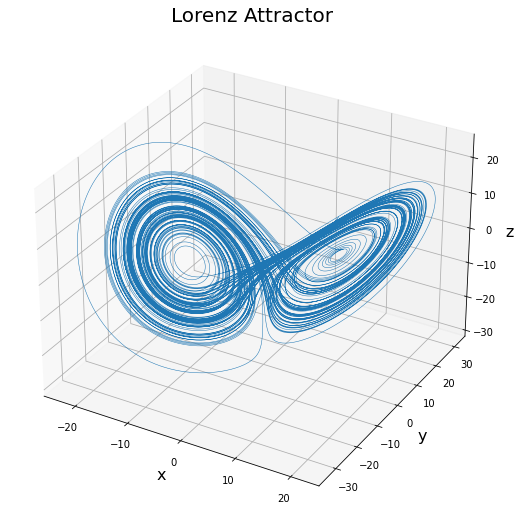

In [7]:
# Simulate Lorenz Attractor
Lor = Lorenz()

time = np.arange(0, 100, Lor.dt)
x = np.zeros((len(time), 3))

for i in range(len(time)):
    Lor.step()
    x[i] = Lor.x

# 3D Plot in xyz space
fig = plt.figure(figsize=(12, 9))
ax = fig.gca(projection='3d')
ax.plot(x[:, 0], x[:, 1], x[:, 2], lw=0.5)
# Increase font for title and axes
ax.set_title('Lorenz Attractor', fontsize=20)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_zlabel('z', fontsize=16)

# Save figure with increased dpi (resolution)
plt.savefig('Lorenz Attractor.png', dpi=300)

## NAF Lorenz

In [8]:
import nengo
from scipy.special import legendre

class Config_params():
    def __init__(self):
        self.dt = 1e-3
        self.seed = 42
        self.n_neurons = 2000
        self.Lr = 1e-4
        self.recurr = True
        
        self.Zdim = 3
        self.Udim = 0

        self.theta_s = 0.2
        self.qs = 3
        self.theta_u = 0.0
        self.qu = 0
        self.recurr = True

        self.blindfrom = 20
        self.no_obs_from = self.blindfrom - 5
        self.debug = True

In [263]:

class LorNet(nengo.Network):
     def __init__(self,  **kwargs):
        super().__init__(**kwargs)
    
        self.env = Lorenz()
        with self:
            def env_step(t):
                self.env.step()
                if t%50==0:
                    print(f"Time {t} \n")
                return (self.env.Z[0], self.env.Z[1], self.env.Z[2])
            
            self.Z = nengo.Node(env_step, size_out=3)


def make_lmu(q=6, theta=1.0):
    Q = np.arange(q, dtype=np.float64)
    R = (2*Q + 1)[:, None] / theta
    j, i = np.meshgrid(Q, Q)

    A = np.where(i < j, -1, (-1.)**(i-j+1)) * R
    B = (-1.)**Q[:, None] * R
    return A, B

def get_weights_for_delays(r, q=6):
    # compute the weights needed to extract the value at time r
    # from the network (r=0 is right now, r=1 is theta seconds ago)
    r = np.asarray(r)
    m = np.asarray([legendre(i)(2*r - 1) for i in range(q)])
    return m.reshape(q,-1).T

In [418]:

class EstNet(nengo.Network):
    def __init__(self, p, Xw=[], no_obs=True, label=None, **kwargs):
        super(EstNet, self).__init__(label=label)
        with self:
            def noobs(t,x):
                interval = 0.5 #secs
                gated = (t>(p.no_obs_from-interval))
                return gated*np.clip((t-p.no_obs_from)/(2*interval), 0, 1)

            def err_fun(t,x):
                return x[0:p.Zdim]*(1 - x[p.Zdim])
        
            def ctxtfn(t,x):
                return x[0:p.Zdim]*(1 - x[2*p.Zdim]) + x[p.Zdim:2*p.Zdim]*x[2*p.Zdim]
            
            taup = 0.1
            self.Z = nengo.Node(size_in=p.Zdim)
            self.X = nengo.Node(size_in=p.Zdim)
            self.context = nengo.Node(ctxtfn, size_in=2*p.Zdim+1)
            

            nengo.Connection(self.Z, self.context[0:p.Zdim])
            nengo.Connection(self.X, self.context[p.Zdim:2*p.Zdim])
            if no_obs:
                self.no_obs = nengo.Node(noobs, size_in=1)
                nengo.Connection(self.no_obs, self.context[2*p.Zdim])
            else:
                self.no_obs = nengo.Node(None, size_in=1)
                nengo.Connection(self.no_obs, self.context[2*p.Zdim])
            
            A, B = make_lmu(q=p.qs, theta=p.theta_s); print('Theta_s: '+str(p.theta_s) + ' Qs: '+str(p.qs))
            As = taup * A + np.eye(A.shape[0])
            Bs = taup * B
            Cs = get_weights_for_delays(0, q=p.qs)


            Q = [];    self.conn = []
            self.err = nengo.Node(err_fun, size_in=p.Zdim+1); nengo.Connection(self.no_obs, self.err[p.Zdim])
            self.adapt = nengo.Ensemble(p.n_neurons, p.Zdim*p.qs + p.Udim*p.qu)
            
            for i in range(p.Zdim):
                Q.append(nengo.Node(None, size_in=p.qs))
                
                nengo.Connection(self.context[i], Q[i], transform=Bs, synapse=taup)
                nengo.Connection(Q[i], Q[i], transform=As, synapse=taup) 
                nengo.Connection(Q[i], self.adapt[i*p.qs:(i+1)*p.qs])
                
                self.conn.append(nengo.Connection(self.adapt.neurons, self.X[i], transform=Xw[i]))
                self.conn[i].learning_rule_type = nengo.PES(learning_rate=p.Lr)                        
                nengo.Connection(self.err[i], self.conn[i].learning_rule)
                
                if p.recurr == True:
                    nengo.Connection(self.X[i], self.X[i], synapse=taup)
                
                nengo.Connection(self.Z[i], self.err[i], transform=-1, synapse=None)
                nengo.Connection(self.X[i], self.err[i], synapse=None)
                
                             
            if p.Udim !=0:
                
                self.U = nengo.Node(size_in=p.Udim)
                A, B = make_lmu(q=p.qu, theta=p.theta_u)
                Cu = get_weights_for_delays(0, q=p.qu)
                Au = taup * A + np.eye(A.shape[0])
                Bu = taup * B

                temp = p.Zdim*p.qs
                for j in range(p.Udim):
                    print("Ctrl, ",j)
                    Q.append(nengo.Node(None, size_in=p.qu))
                    nengo.Connection(Q[p.Zdim+j], Q[p.Zdim+j], transform=Au, synapse=taup)
                    nengo.Connection(self.U[j], Q[p.Zdim+j], transform=Bu, synapse=taup)
                    nengo.Connection(Q[p.Zdim+j], self.adapt[temp+j*p.qu:temp+(j+1)*p.qu])

            if p.debug == True:
                self.Check = nengo.Node(size_in=1)
                # nengo.Connection(self.adapt[4*p.qs:4*p.qs+p.qu], self.Check, transform=Cu, synapse=None)
                
                
                # self.Check2 = nengo.Node(size_in=1)
                nengo.Connection(self.adapt[1*p.qs:2*p.qs], self.Check, transform=Cs)

In [419]:


def sim_Lor_NAF(p):
    print(f"Simulating for {p.blindfrom} seconds")
    model = nengo.Network()
    with model:
        
        # model.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
               
        theta_s = p.theta_s
        qs = p.qs
        
        Lr = p.Lr
        no_obs_from = p.no_obs_from
        
        n_neurons = p.n_neurons
        recurr = True #
        
        
    #     xw = np.load('Weightnafl.npz')['Xw']
    #     yw = np.load('Weightnafl.npz')['Yw']
    #     zw = np.load('Weightnafl.npz')['Zw']

        
        xw = 1e-6*np.zeros((1, p.n_neurons))
        yw = 1e-6*np.zeros((1, p.n_neurons))
        zw = 1e-6*np.zeros((1, p.n_neurons))
        
        W = [xw, yw, zw]
        
        env = LorNet()         
        est = EstNet(p, Xw=W
        )
        nengo.Connection(env.Z, est.Z)
        
        Zp_ = nengo.Probe(est.Z, synapse=0.01)
        Xp_ = nengo.Probe(est.X, synapse=0.01)
        Err_ = nengo.Probe(est.err, synapse=0.01)
        
        xw = nengo.Probe(est.conn[0], 'weights', sample_every=p.blindfrom - 10)
        yw = nengo.Probe(est.conn[1], 'weights', sample_every=p.blindfrom - 10)
        zw = nengo.Probe(est.conn[2], 'weights', sample_every=p.blindfrom - 10)
        
        No_ = nengo.Probe(est.no_obs, synapse=0.01)
        c_ = nengo.Probe(est.Check, synapse=0.01)



    with nengo.Simulator(model) as sim: 
        sim.run(p.blindfrom)

    T = sim.trange()
    Z = sim.data[Zp_]
    X = sim.data[Xp_]
    Err = sim.data[Err_]
    No = sim.data[No_]
    c = sim.data[c_]
    Xw = []
    Xw.append(sim.data[xw][-1])
    Xw.append(sim.data[yw][-1])
    Xw.append(sim.data[zw][-1])

    return T, Z, X, Err, No, c, Xw

In [513]:


p = Config_params()

p.n_neurons = 200
p.blindfrom = 500
p.no_obs_from = p.blindfrom - 5

p.recurr = False
p.theta_s = 0.01
p.qs = 10
np.random.seed(p.seed)
probes_Lor_new = sim_Lor_NAF(p)

# 4 mins 30 secs for 500s

Simulating for 500 seconds
[ 4.96714153 -1.38264301  6.47688538]
Theta_s: 0.01 Qs: 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Time 50.0 

Time 100.0 

Time 150.0 

Time 200.0 

Time 250.0 

Time 300.0 

Time 350.0 

Time 400.0 

Time 450.0 

Time 500.0 



(500000, 3)


'theta_s: 0.01 qs: 2 blindfrom: 500 V_x: 0.752 V_y: 0.665 V_z: 0.6960000000000001'

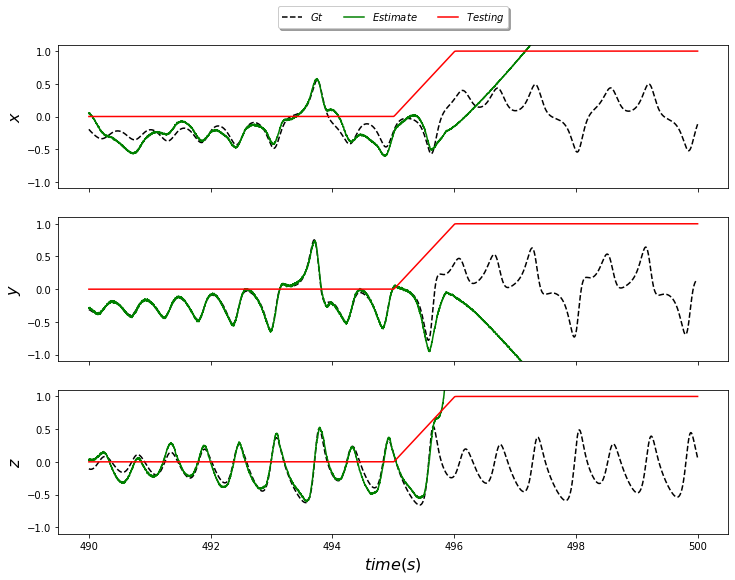

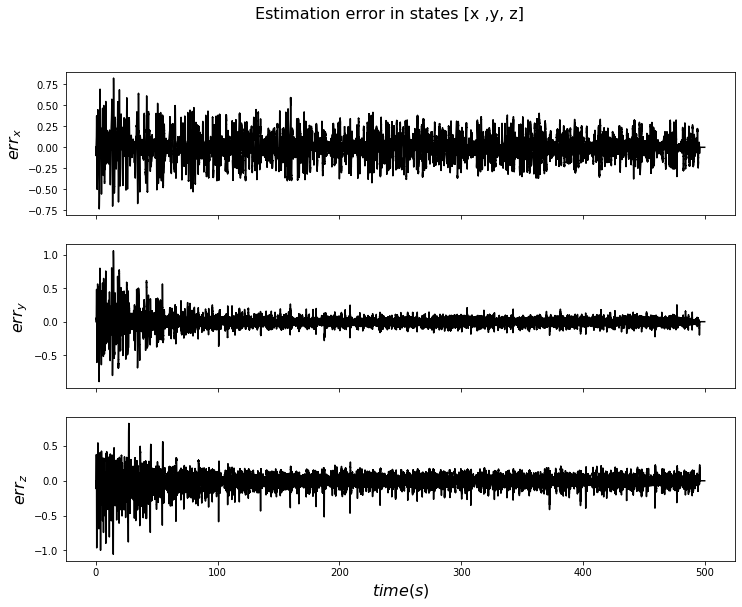

In [514]:
ind0 = -10 #p.blindfrom - 8
plot_probes(p, probes_Lor_new, ind0, indf)

In [358]:
# Save Xw
# T, Z, X, Err, No, c, Xw = probes_Lor
# file_name = f'Lor_NAF_Xw_blindfrom_{p.blindfrom}_theta_s_{p.theta_s}_qs_{p.qs}_n_neurons_{p.n_neurons}.npz'
# np.savez(file_name, Xw=Xw)
# print(f"Saved {file_name}")

# # Save probes 
# file_name = f'Lor_NAF_blindfrom_{p.blindfrom}_theta_s_{p.theta_s}_qs_{p.qs}_n_neurons_{p.n_neurons}.npz'
# # Save T, Z, X, Err, No, c, p
# np.savez(file_name, T=T, Z=Z, X=X, Err=Err, No=No, c=c, p=p)



# # Loaf .npz file
# file_name = f'Lor_NAF_blindfrom_1500_theta_s_0.05_qs_5_n_neurons_1000.npz'
# probes_Lor = np.load(file_name)
# len(probes_Lor)

Saved Lor_NAF_Xw_blindfrom_1500_theta_s_0.05_qs_5_n_neurons_1000.npz


### Plot

In [6]:
import dill as pickle
# # # Loaf .npz file
# file_name = 'Lor_NAF_blindfrom_1500_theta_s_0.05_qs_5_n_neurons_1000.npz'


# # Loaf .npz file
# file_name = f'Lor_NAF_blindfrom_1500_theta_s_0.05_qs_5_n_neurons_1000.npz'
# probes_Lor = np.load(file_name)
# len(probes_Lor)

# # Load the file
# data = np.load(file_name, allow_pickle=True)
# # Get the data
# T = data['T']
# Z = data['Z']
# X = data['X']
# Err = data['Err']
# No = data['No']
# c = data['c']
# p = data['p'].item()

# probes_loaded = [T, Z, X, Err, No, c, p]


In [3]:

# T, Z, X, Err, No, c, Xw = probes_Lor

def plot_probes(p, probes_Lor, ind0, indf, probes_plot =True, err_plot=True, plot_3D = False):
    
    T, Z, X, Err, No, c, _ = probes_Lor
    if indf != -1:
        indf = indf*1000
    ind0 = ind0*1000

    if probes_plot:
        fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
        ax[0].plot(T[ind0:indf], Z[ind0:indf, 0], 'k--', label='$Gt$')
        ax[0].plot(T[ind0:indf], X[ind0:indf, 0], 'g', label='$Estimate$')
        ax[0].plot(T[ind0:indf], No[ind0:indf, 0], 'r', label='$Testing$')
        ax[0].set_ylabel('$x$', fontsize=16)


        ax[1].plot(T[ind0:indf], Z[ind0:indf, 1], 'k--', label='$Gt$')
        ax[1].plot(T[ind0:indf], X[ind0:indf, 1], 'g', label='$Estimate$')
        ax[1].plot(T[ind0:indf], No[ind0:indf, 0], 'r', label='$Testing$')
        ax[1].set_ylabel('$y$', fontsize=16)
        # ax[1].plot(T[ind0:indf], c[ind0:indf], 'r')

        ax[2].plot(T[ind0:indf], Z[ind0:indf, 2], 'k--', label='$Gt$')
        ax[2].plot(T[ind0:indf], X[ind0:indf, 2], 'g', label='$Estimate$')
        ax[2].plot(T[ind0:indf], No[ind0:indf, 0], 'r', label='$Testing$')
        ax[2].set_ylabel('$z$', fontsize=16)
        ax[2].set_xlabel('$time (s)$', fontsize=16)

        ax[0].set_ylim([-1.1, 1.1]); ax[1].set_ylim([-1.1, 1.1]); ax[2].set_ylim([-1.1, 1.1])

    # The legends on the top. Remove duplicates
    handles, labels = ax[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[0].legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.3),
                ncol=3, fancybox=True, shadow=True)
                

    # Err plot
    if err_plot:
        fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
        ind0 = 0
        indf = -1
        ax[0].plot(T[ind0:indf], Err[ind0:indf, 0], 'k', label='$err_x$')
        ax[0].set_ylabel('$err_x$', fontsize=16)

        ax[1].plot(T[ind0:indf], Err[ind0:indf, 1], 'k', label='$err_y$')
        ax[1].set_ylabel('$err_y$', fontsize=16)

        ax[2].plot(T[ind0:indf], Err[ind0:indf, 2], 'k', label='$err_z$')
        ax[2].set_ylabel('$err_z$', fontsize=16)
        ax[2].set_xlabel('$time (s)$', fontsize=16)

        # Overall title
        fig.suptitle(f'Estimation error in states [x ,y, z]', fontsize=16)

    if plot_3D:
        # Plot GT in black and estimate in green
        fig = plt.figure(figsize=(12, 9))
        ax = fig.gca(projection='3d')
        ax.plot(Z[ind0:indf, 0], Z[ind0:indf, 1], Z[ind0:indf, 2], 'k--', label='$Gt$')
        ax.plot(X[ind0:indf, 0], X[ind0:indf, 1], X[ind0:indf, 2], 'g', label='$Estimate$')

    # Metrics
    thresh_x = 0.05
    thresh_y = 0.05
    thresh_z = 0.05

    dt = p.dt

    no_obs_ind = int(p.no_obs_from*1000)
    print(Z.shape)
    err_x = np.abs(X[no_obs_ind:-1, 0] - Z[no_obs_ind:-1, 0])
    err_y = np.abs(X[no_obs_ind:-1, 1] - Z[no_obs_ind:-1, 1])
    err_z = np.abs(X[no_obs_ind:-1, 2] - Z[no_obs_ind:-1, 2])

    cumperr_x = np.cumsum(err_x*dt)
    cumverr_y = np.cumsum(err_y*dt)
    cumverr_z = np.cumsum(err_z*dt)

    try:
        V_x = dt*np.where(cumperr_x<thresh_x)[-1][-1]
        V_y = dt*np.where(cumverr_y<thresh_y)[-1][-1]
        V_z = dt*np.where(cumverr_z<thresh_z)[-1][-1]

    except:
        V_x = 0
        V_y = 0
        V_z = 0

    metric = f"theta_s: {p.theta_s} qs: {p.qs} blindfrom: {p.blindfrom} V_x: {V_x} V_y: {V_y} V_z: {V_z}"
    # 'theta_s': p.theta_s, 'qs': p.qs, 'p.blinfrom': p.blindfrom, 'V_x': V_x, 'V_y': V_y, 'V_z': V_z

    
    return metric


(1500000, 3)


'theta_s: 0.05 qs: 5 blindfrom: 1500 V_x: 1.596 V_y: 1.363 V_z: 1.328'

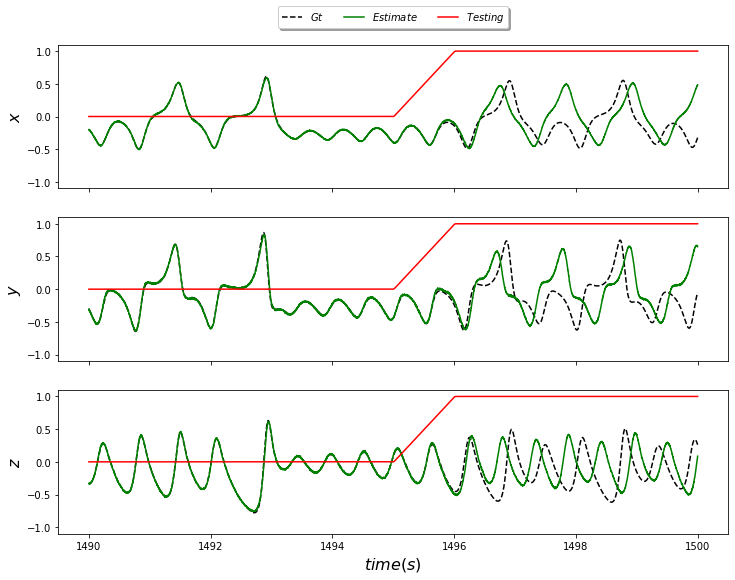

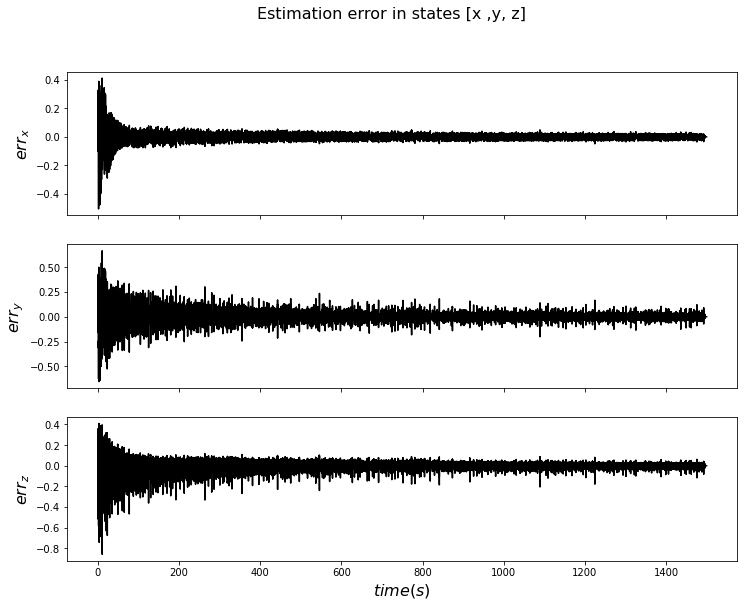

In [500]:
ind0 = -10 #p.blindfrom - 8
plot_probes(p, probes_loaded, ind0, indf)

In [97]:
"""
 'theta_s: 0.05 qs: 2 blindfrom: 200 V_x: 0.763 V_y: 0.532 V_z: 0.69'
 'theta_s: 0.5 qs: 4 blindfrom: 200 V_x: 0.881 V_y: 0.361 V_z: 0.278'
 'theta_s: 0.1 qs: 4 blindfrom: 500 V_x: 0.97 V_y: 0.904 V_z: 0.865'

 """

"\n 'theta_s: 0.05 qs: 2 blindfrom: 200 V_x: 0.763 V_y: 0.532 V_z: 0.69'\n 'theta_s: 0.5 qs: 4 blindfrom: 200 V_x: 0.881 V_y: 0.361 V_z: 0.278'\n\n "

In [308]:
x_data = x
time_data = time

x_sim = Z
time_sim = T

direct_test = True
if direct_test:
    train_data = x
    test_data = x_sim[no_obs_ind:no_obs_ind+5000]*35
    sindy_scale = 35
else:
    no_obs_ind = int(p.no_obs_from*1000)
    train_data = x_sim
    test_data = x_sim[no_obs_ind:no_obs_ind+5000]
    sindy_scale = 1
    
x_sim_to_plot = X[no_obs_ind:no_obs_ind+5000]

(x)' = -9.980 x + 10.000 y
(y)' = -0.962 y + -1.000 x z
(z)' = -102.393 1 + -2.604 z + 1.000 x y
Initial condition: [[ 4.74405946 -0.90553254 -0.627517  ]] 

SINDY: V_x: 2.47 V_y: 2.216 V_z: 1.969
NAF: V_x: 1.453 V_y: 1.41 V_z: 1.491


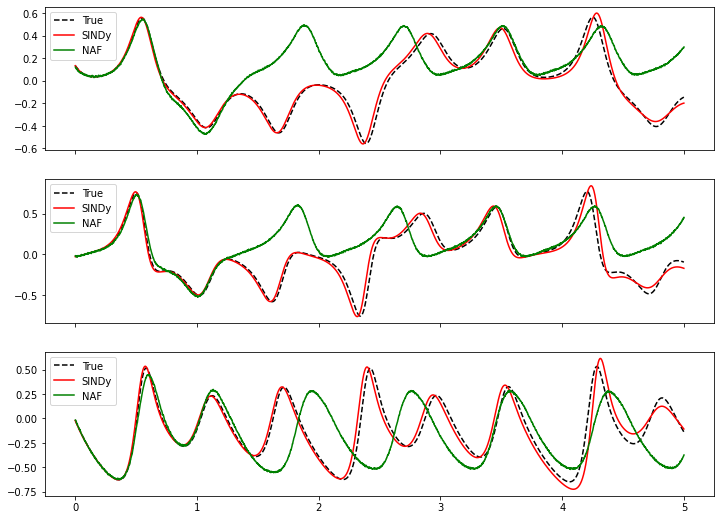

In [310]:
from scipy.integrate import solve_ivp
import pysindy as ps

def give_sindy_metric(train_data, test_data, x_sim_to_plot, sindy_scale):
    N = 5000
    # Instantiate and fit the SINDYc model
    poly_library = ps.PolynomialLibrary()
    fourier_library = ps.FourierLibrary()
    combined_library = poly_library + fourier_library

    feature_names=['x', 'y', 'z']
    model3 = ps.SINDy(
        feature_library=combined_library,
        feature_names=feature_names
        )

    model3.fit(train_data, t=1e-3)
    model3.get_feature_names()
    model3.print()

    x_i = test_data[0].reshape(1,3)

    print(f"Initial condition: {x_i} \n")
    x_sindy = np.zeros((N, 3))

    for i in range(N):
        x_dot_out = model3.predict(x_i)
        x_i = x_i + x_dot_out*1e-3
        x_sindy[i] = x_i

    # Plot the results
    fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    for i in range(3):
        ax[i].plot(time_data[:N], test_data[:N, i]/sindy_scale, 'k--', label="True")
        ax[i].plot(time_data[:N], x_sindy[:N, i]/sindy_scale, 'r',label="SINDy")
        ax[i].plot(time_sim[:N], x_sim_to_plot[:N, i], 'g',label="NAF")
        ax[i].legend()
    return x_sindy

def get_metrics(x, GT, str_):
    
    #Get metrics
    thresh_x = 0.05
    thresh_y = 0.05
    thresh_z = 0.05

    err_x = np.abs(x[:N, 0] - GT[:N, 0])
    err_y = np.abs(x[:N, 1] - GT[:N, 1])
    err_z = np.abs(x[:N, 2] - GT[:N, 2])

    cumperr_x = np.cumsum(err_x*dt)
    cumverr_y = np.cumsum(err_y*dt)
    cumverr_z = np.cumsum(err_z*dt)

    try:
        V_x = dt*np.where(cumperr_x<thresh_x)[-1][-1]
        V_y = dt*np.where(cumverr_y<thresh_y)[-1][-1]
        V_z = dt*np.where(cumverr_z<thresh_z)[-1][-1]

    except:
        V_x = -1
        V_y = -1
        V_z = -1
    print(f"{str_}: V_x: {V_x} V_y: {V_y} V_z: {V_z}")


x_sindy = give_sindy_metric(train_data, test_data, x_sim_to_plot, sindy_scale)

get_metrics(x_sindy/sindy_scale, test_data/sindy_scale, 'SINDY')
get_metrics(x_sim_to_plot, test_data/sindy_scale, 'NAF')


In [257]:
test_data/sindy_scale

array([[ 0.13554456, -0.02587236, -0.01792906],
       [ 0.13393039, -0.02578547, -0.02093651],
       [ 0.13233323, -0.02568529, -0.02393422],
       ...,
       [-0.14627211, -0.092437  , -0.13357158],
       [-0.14573376, -0.09302222, -0.13567685],
       [-0.14520665, -0.09361521, -0.13777527]])

### 5 simulation

In [428]:
## 5 simulation
for i in range(5):
    p = Config_params()

    p.n_neurons = 1000
    p.blindfrom = 1500
    p.no_obs_from = p.blindfrom - 5

    p.recurr = False
    p.theta_s = 0.05
    p.qs = 5

    probes_Lor = sim_Lor_NAF(p)

    
    T, Z, X, Err, No, c, Xw = probes_Lor

    file_name = f'data/S_bf_{p.blindfrom}_theta_s_{p.theta_s}_qs_{p.qs}_n_neurons_{p.n_neurons}_ver_{i}.npz'
    np.savez(file_name, T=T, Z=Z, X=X, Err=Err, No=No, c=c, p=p)

Simulating for 1500 seconds
[-10.1283112    3.14247333  -9.08024076]
Theta_s: 0.05 Qs: 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Time 50.0 

Time 100.0 

Time 150.0 

Time 200.0 

Time 250.0 

Time 300.0 

Time 350.0 

Time 400.0 

Time 450.0 

Time 500.0 

Time 550.0 

Time 600.0 

Time 650.0 

Time 700.0 

Time 750.0 

Time 800.0 

Time 850.0 

Time 900.0 

Time 950.0 

Time 1000.0 

Time 1050.0 

Time 1100.0 

Time 1150.0 

Time 1200.0 

Time 1250.0 

Time 1300.0 

Time 1350.0 

Time 1400.0 

Time 1450.0 

Time 1500.0 

Simulating for 1500 seconds
[-14.12303701  -6.29474961   5.97720467]
Theta_s: 0.05 Qs: 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Time 50.0 

Time 100.0 

Time 150.0 

Time 200.0 

Time 250.0 

Time 300.0 

Time 350.0 

Time 400.0 

Time 450.0 

Time 500.0 

Time 550.0 

Time 600.0 

Time 650.0 

Time 700.0 

Time 750.0 

Time 800.0 

Time 850.0 

Time 900.0 

Time 950.0 

Time 1000.0 

Time 1050.0 

Time 1100.0 

Time 1150.0 

Time 1200.0 

Time 1250.0 

Time 1300.0 

Time 1350.0 

Time 1400.0 

Time 1450.0 

Time 1500.0 

Simulating for 1500 seconds
[ -5.44382725   1.1092259  -11.50993577]
Theta_s: 0.05 Qs: 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Time 50.0 

Time 100.0 

Time 150.0 

Time 200.0 

Time 250.0 

Time 300.0 

Time 350.0 

Time 400.0 

Time 450.0 

Time 500.0 

Time 550.0 

Time 600.0 

Time 650.0 

Time 700.0 

Time 750.0 

Time 800.0 

Time 850.0 

Time 900.0 

Time 950.0 

Time 1000.0 

Time 1050.0 

Time 1100.0 

Time 1150.0 

Time 1200.0 

Time 1250.0 

Time 1300.0 

Time 1350.0 

Time 1400.0 

Time 1450.0 

Time 1500.0 

Simulating for 1500 seconds
[ 3.75698018 -6.0025385   9.47439821]
Theta_s: 0.05 Qs: 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Time 50.0 

Time 100.0 

Time 150.0 

Time 200.0 

Time 250.0 

Time 300.0 

Time 350.0 

Time 400.0 

Time 450.0 

Time 500.0 

Time 550.0 

Time 600.0 

Time 650.0 

Time 700.0 

Time 750.0 

Time 800.0 

Time 850.0 

Time 900.0 

Time 950.0 

Time 1000.0 

Time 1050.0 

Time 1100.0 

Time 1150.0 

Time 1200.0 

Time 1250.0 

Time 1300.0 

Time 1350.0 

Time 1400.0 

Time 1450.0 

Time 1500.0 

Simulating for 1500 seconds
[-6.01706612 18.52278185 -0.13497225]
Theta_s: 0.05 Qs: 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Time 50.0 

Time 100.0 

Time 150.0 

Time 200.0 

Time 250.0 

Time 300.0 

Time 350.0 

Time 400.0 

Time 450.0 

Time 500.0 

Time 550.0 

Time 600.0 

Time 650.0 

Time 700.0 

Time 750.0 

Time 800.0 

Time 850.0 

Time 900.0 

Time 950.0 

Time 1000.0 

Time 1050.0 

Time 1100.0 

Time 1150.0 

Time 1200.0 

Time 1250.0 

Time 1300.0 

Time 1350.0 

Time 1400.0 

Time 1450.0 

Time 1500.0 



(1500000, 3)


'theta_s: 0.05 qs: 5 blindfrom: 1500 V_x: 1.596 V_y: 1.363 V_z: 1.328'

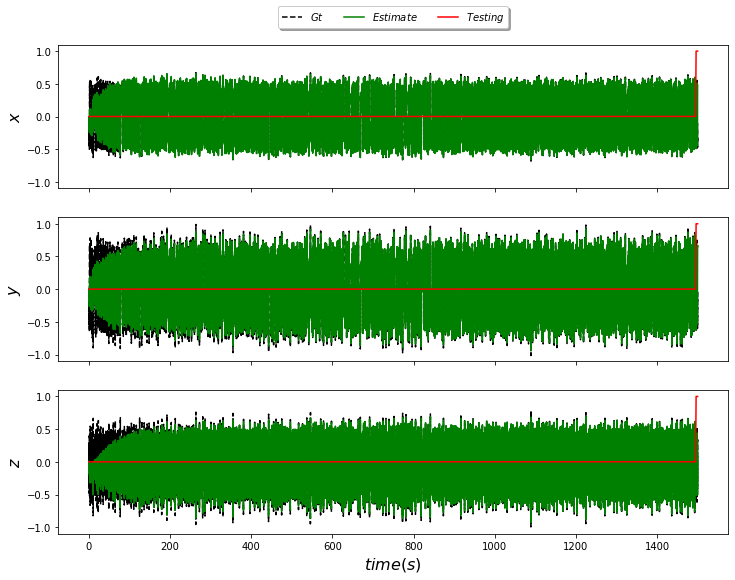

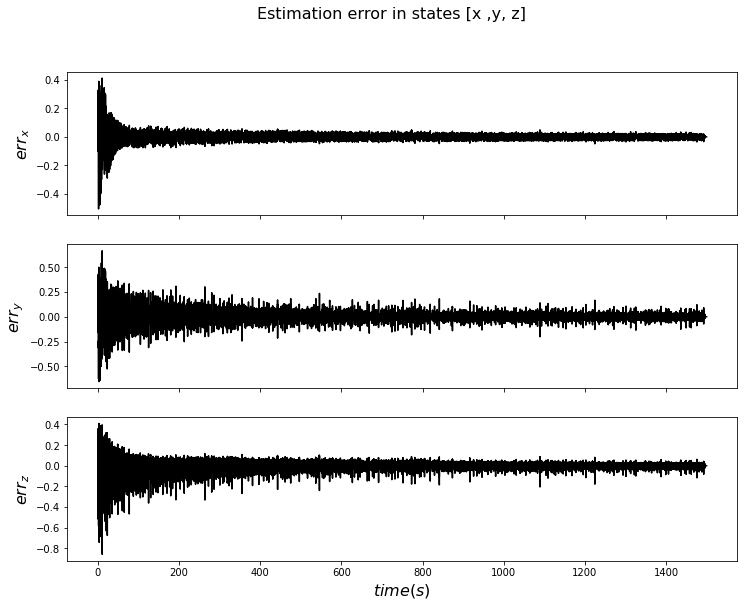

In [14]:
# Plot first simulation
file_name0 = f'data\S_bf_1500_theta_s_0.05_qs_5_n_neurons_1000_ver_0.npz' #V_x: 1.357 V_y: 1.181 V_z: 1.172
file_name1 = f'data\S_bf_1500_theta_s_0.05_qs_5_n_neurons_1000_ver_1.npz' #V_x: 1.596 V_y: 1.363 V_z: 1.328
file_name2 = f'data\S_bf_1500_theta_s_0.05_qs_5_n_neurons_1000_ver_2.npz' #V_x: 1.343 V_y: 1.232 V_z: 1.384
file_name3 = f'data\S_bf_1500_theta_s_0.05_qs_5_n_neurons_1000_ver_3.npz' #V_x: 1.406 V_y: 1.292 V_z: 1.243
file_name4 = f'data\S_bf_1500_theta_s_0.05_qs_5_n_neurons_1000_ver_4.npz' #V_x: 1.325 V_y: 1.192 V_z: 1.342


# Load the file
data = np.load(file_name1, allow_pickle=True)
# Get the data
T = data['T']
Z = data['Z']
X = data['X']
Err = data['Err']
No = data['No']
c = data['c']
p = data['p'].item()

probes_loaded = [T, Z, X, Err, No, c, p]

# Plot
ind0 = 0 #p.blindfrom - 8
indf = -1
plot_probes(p, probes_loaded, ind0, indf)

In [474]:


Z_all = []
X_all = []

for i in range(5):
    file_name = f'data\S_bf_1500_theta_s_0.05_qs_5_n_neurons_1000_ver_{i}.npz'
    probes_loaded = np.load(file_name)
    T = probes_loaded['T']
    Z = probes_loaded['Z']
    X = probes_loaded['X']
    
    Z_all.append(Z)
    X_all.append(X)

# len(probes_Lor)

# # Load the file
# data = np.load(file_name, allow_pickle=True)
# Get the data
# T = data['T']
# Z = data['Z']
# X = data['X']
# Err = data['Err']
# No = data['No']
# c = data['c']
# p = data['p'].item()

# probes_loaded = [T, Z, X, Err, No, c, p]
# 
# 

TypeError: string indices must be integers

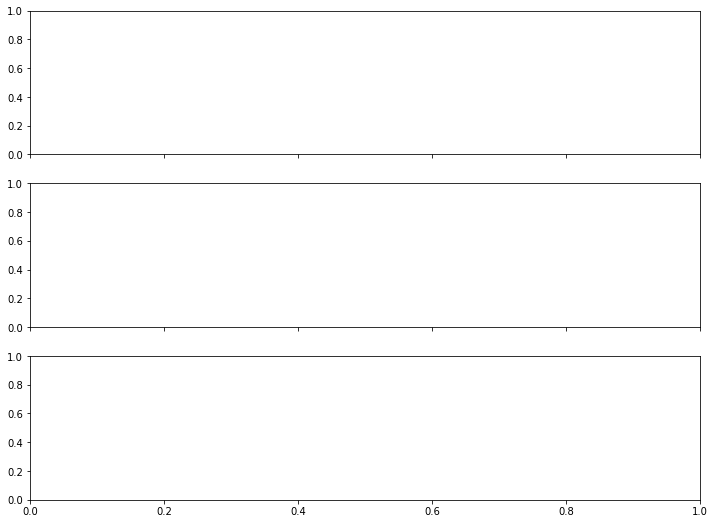

In [477]:
ind0 = -10 #p.blindfrom - 8
plot_probes(p, probes_loaded, ind0, indf)

Mean Vx: 1.405 Vy: 1.252 Vz: 1.294 Std Vx: 0.099 Vy: 0.068 Vz: 0.076
Mean Sx: 2.367 Sy: 2.011 Sz: 1.937 Std Sx: 0.458 Sy: 0.331 Sz: 0.302


Text(0.5, 1.0, 'Z')

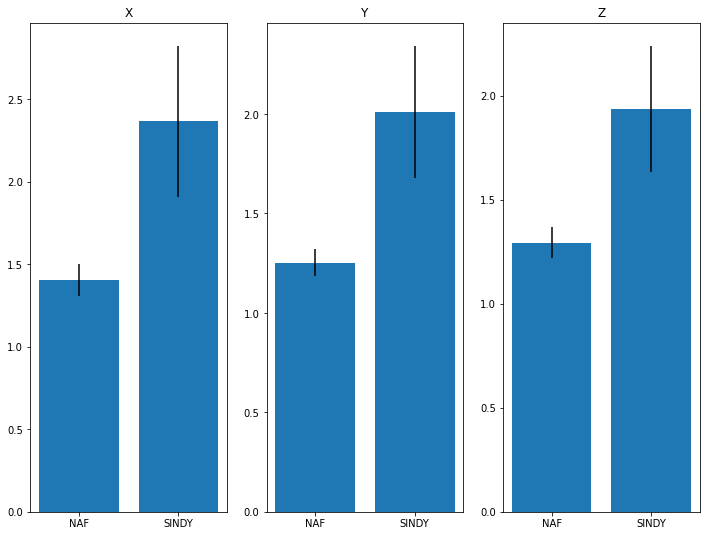

In [476]:

# 1
# SINDY: V_x: 2.692 V_y: 2.266 V_z: 2.024
# NAF: V_x: 1.357 V_y: 1.181 V_z: 1.172
# 2
# SINDY: V_x: 1.736 V_y: 1.469 V_z: 1.356
# NAF: V_x: 1.596 V_y: 1.363 V_z: 1.328
# 3
# SINDY: V_x: 2.638 V_y: 2.297 V_z: 2.242
# NAF: V_x: 1.343 V_y: 1.232 V_z: 1.384
# 4
# SINDY: V_x: 1.899 V_y: 1.779 V_z: 2.031
# NAF: V_x: 1.406 V_y: 1.292 V_z: 1.243
# 5
# SINDY: V_x: 2.868 V_y: 2.245 V_z: 2.0340
# NAF: V_x: 1.325 V_y: 1.192 V_z: 1.342


# Get the average of the 5 simulations
Vx_list = [1.357, 1.596, 1.343, 1.406, 1.325]
Vy_list = [1.181, 1.363, 1.232, 1.292, 1.192]
Vz_list = [1.172, 1.328, 1.384, 1.243, 1.342]

Sx_list = [2.692, 1.736, 2.638, 1.899, 2.868]
Sy_list = [2.266, 1.469, 2.297, 1.779, 2.245]
Sz_list = [2.024, 1.356, 2.242, 2.031, 2.034]

Vx = np.mean(Vx_list); Vy = np.mean(Vy_list);Vz = np.mean(Vz_list); Std_v_x = np.std(Vx_list); Std_v_y = np.std(Vy_list); Std_v_z = np.std(Vz_list)
Sx = np.mean(Sx_list); Sy = np.mean(Sy_list);Sz = np.mean(Sz_list); Std_s_x = np.std(Sx_list); Std_s_y = np.std(Sy_list); Std_s_z = np.std(Sz_list)

# Print the mean and std with only 3 decimals
print(f"Mean Vx: {Vx:.3f} Vy: {Vy:.3f} Vz: {Vz:.3f} Std Vx: {Std_v_x:.3f} Vy: {Std_v_y:.3f} Vz: {Std_v_z:.3f}")
print(f"Mean Sx: {Sx:.3f} Sy: {Sy:.3f} Sz: {Sz:.3f} Std Sx: {Std_s_x:.3f} Sy: {Std_s_y:.3f} Sz: {Std_s_z:.3f}")

# NaF vs Sindy barplot with error bars
fig, ax = plt.subplots(1, 3, figsize=(12, 9), sharex=True)
ax[0].bar(['NAF', 'SINDY'], [Vx, Sx], yerr=[Std_v_x, Std_s_x])
ax[0].set_title('X')
ax[1].bar(['NAF', 'SINDY'], [Vy, Sy], yerr=[Std_v_y, Std_s_y])
ax[1].set_title('Y')
ax[2].bar(['NAF', 'SINDY'], [Vz, Sz], yerr=[Std_v_z, Std_s_z])
ax[2].set_title('Z')



### Sindy metrics

(x)' = -9.981 x + 9.999 y
(y)' = -0.267 x + -0.802 y + -0.991 x z
(z)' = -101.841 1 + -2.582 z + 0.999 x y
Initial condition: [[ -0.49681839  -0.5280451  -16.75298888]] 

SINDY: V_x: 2.692 V_y: 2.266 V_z: 2.024
NAF: V_x: 1.357 V_y: 1.181 V_z: 1.172
(x)' = -9.980 x + 9.999 y
(y)' = -0.265 x + -0.803 y + -0.991 x z
(z)' = -101.821 1 + -2.582 z + 0.999 x y
Initial condition: [[-13.81274965 -15.30242555   3.02463204]] 

SINDY: V_x: 1.736 V_y: 1.469 V_z: 1.356
NAF: V_x: 1.596 V_y: 1.363 V_z: 1.328
(x)' = -9.982 x + 9.999 y
(y)' = -0.267 x + -0.802 y + -0.991 x z
(z)' = -101.843 1 + -2.582 z + 0.999 x y
Initial condition: [[20.48877856 25.24978286 11.42429275]] 

SINDY: V_x: 2.638 V_y: 2.297 V_z: 2.242
NAF: V_x: 1.343 V_y: 1.232 V_z: 1.3840000000000001
(x)' = -9.981 x + 9.999 y
(y)' = -0.270 x + -0.800 y + -0.991 x z
(z)' = -101.806 1 + -2.581 z + 0.999 x y
Initial condition: [[ 7.75746535 10.33607312 -7.96091494]] 

SINDY: V_x: 1.899 V_y: 1.7790000000000001 V_z: 2.031
NAF: V_x: 1.4060000000

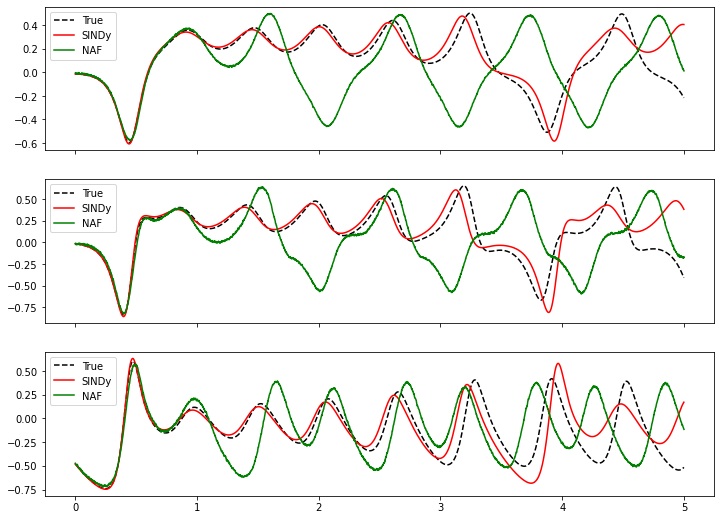

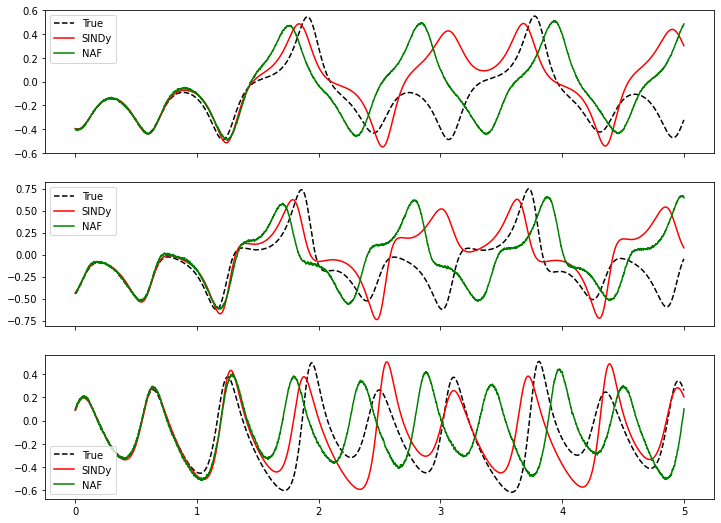

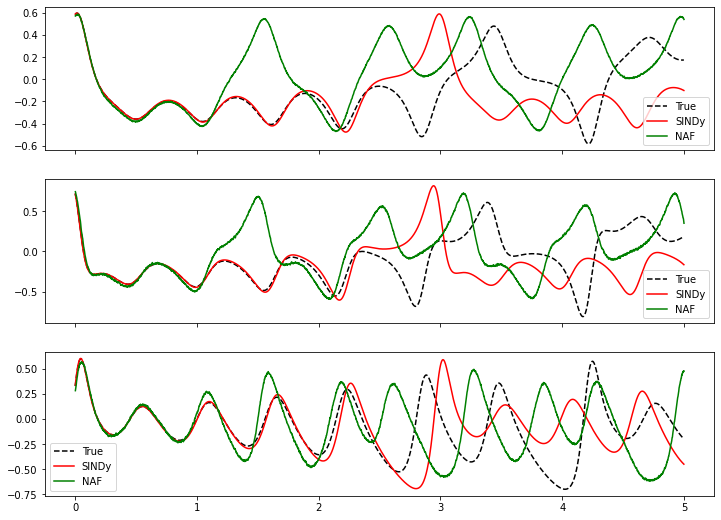

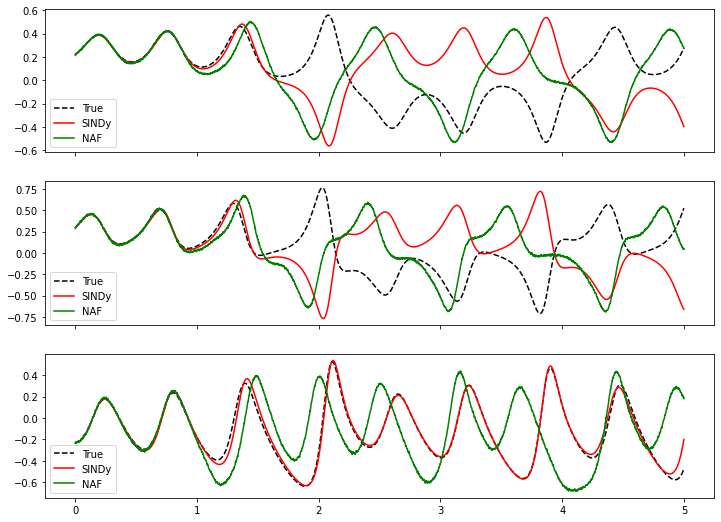

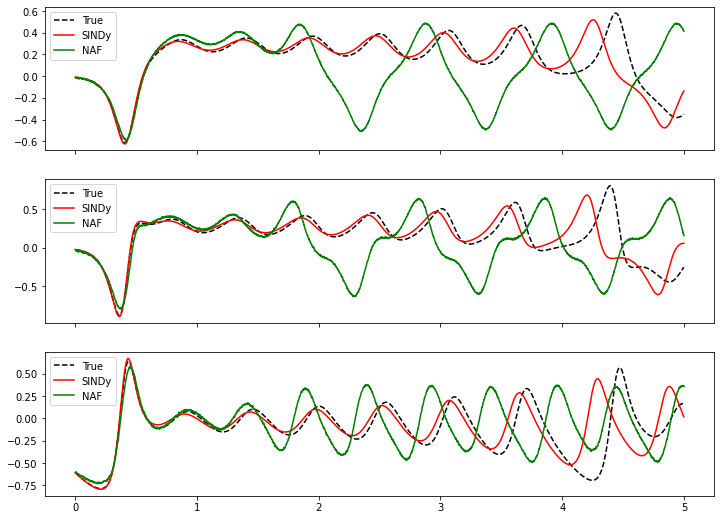

In [475]:


for i in range(5):

    # x_data = x
    # time_data = time

    Z = Z_all[i]
    time_sim = T
    X = X_all[i]
    no_obs_ind = p.no_obs_from*1000

    direct_test = True
    if direct_test:
        train_data = Z[:]*35
        test_data = Z[no_obs_ind:no_obs_ind+5000]*35
        sindy_scale = 35
    else:
        train_data = x_sim
        test_data = x_sim[no_obs_ind:no_obs_ind+5000]
        sindy_scale = 1

    x_sim_to_plot = X[no_obs_ind:no_obs_ind+5000]
    x_sindy = give_sindy_metric(train_data, test_data, x_sim_to_plot, sindy_scale)

    get_metrics(x_sindy/sindy_scale, test_data/sindy_scale, 'SINDY')
    get_metrics(x_sim_to_plot, test_data/sindy_scale, 'NAF')

(1500000, 3)


'theta_s: 0.05 qs: 5 blindfrom: 1500 V_x: 1.357 V_y: 1.181 V_z: 1.172'

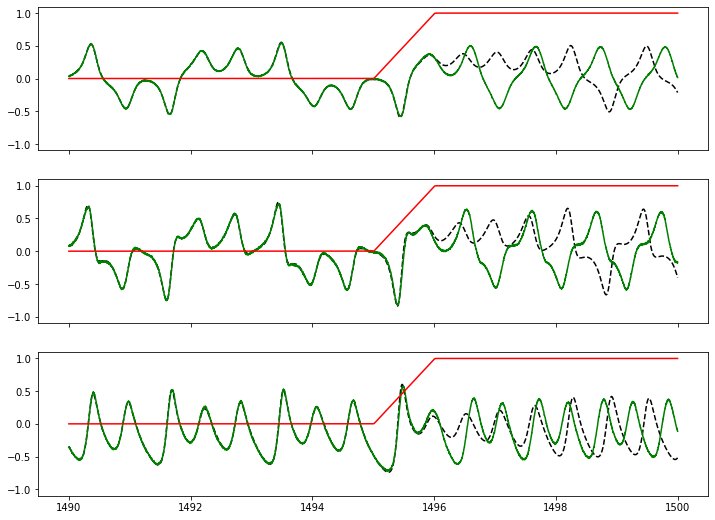

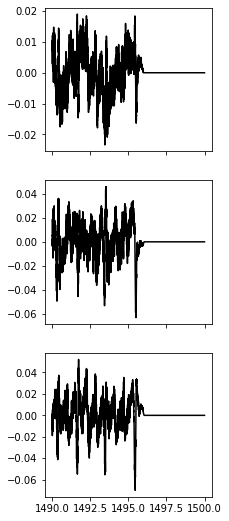

In [459]:

plot_probes(p, probes_loaded, ind0, indf)

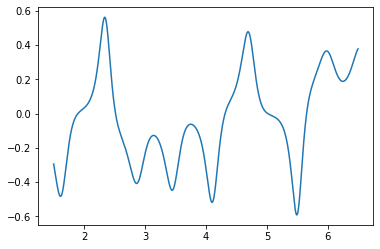

In [469]:
Z = Z_all[i]
plt.plot(T[p.no_obs_from:p.no_obs_from+5000], Z[p.no_obs_from:p.no_obs_from+5000, 0])

In [470]:
p.no_obs_from

1495